<a href="https://colab.research.google.com/github/MiaLiu123/Data-Mining/blob/main/Assignment1/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task 1B

Observe that NA only happens on valence and arousal.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

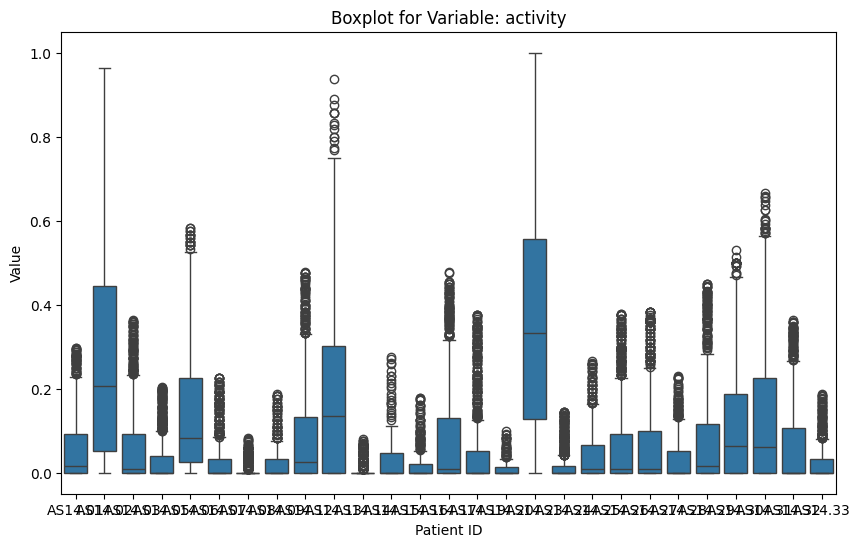

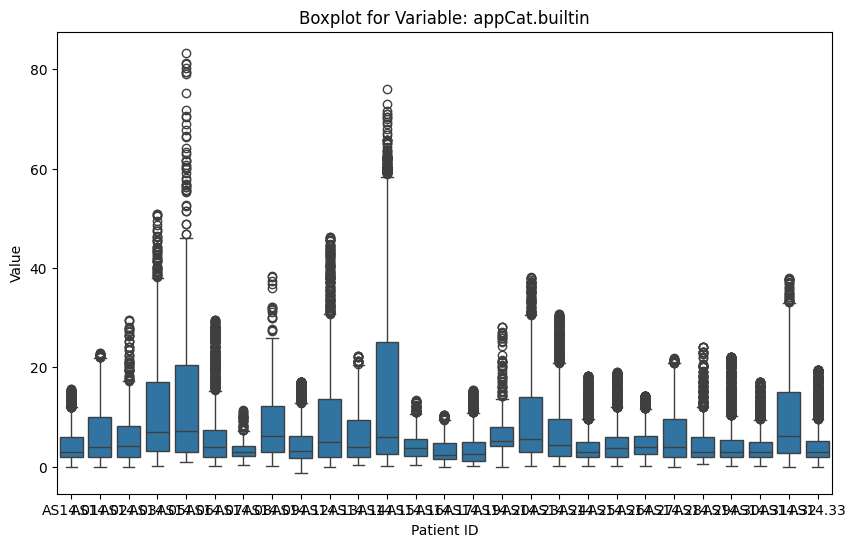

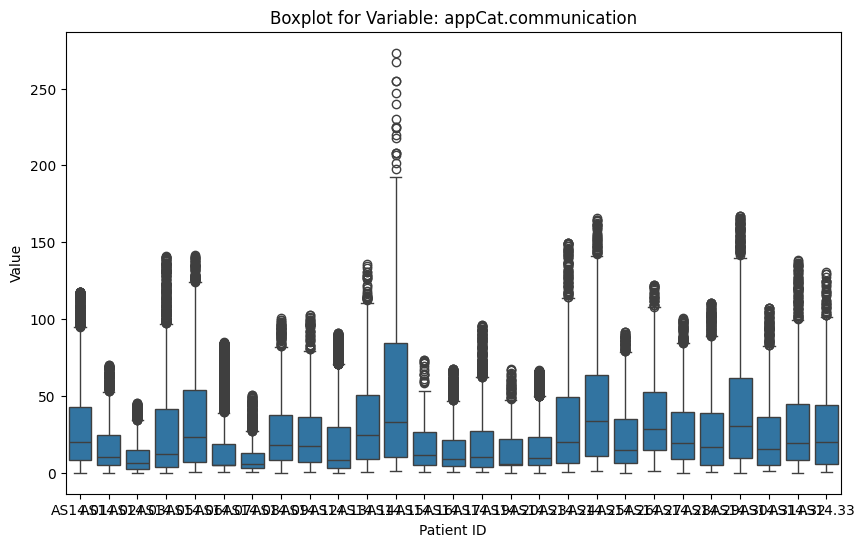

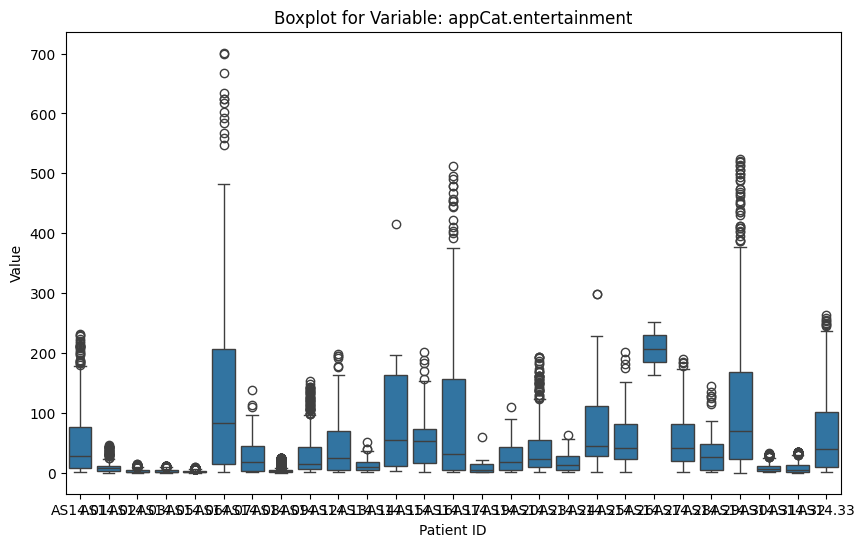

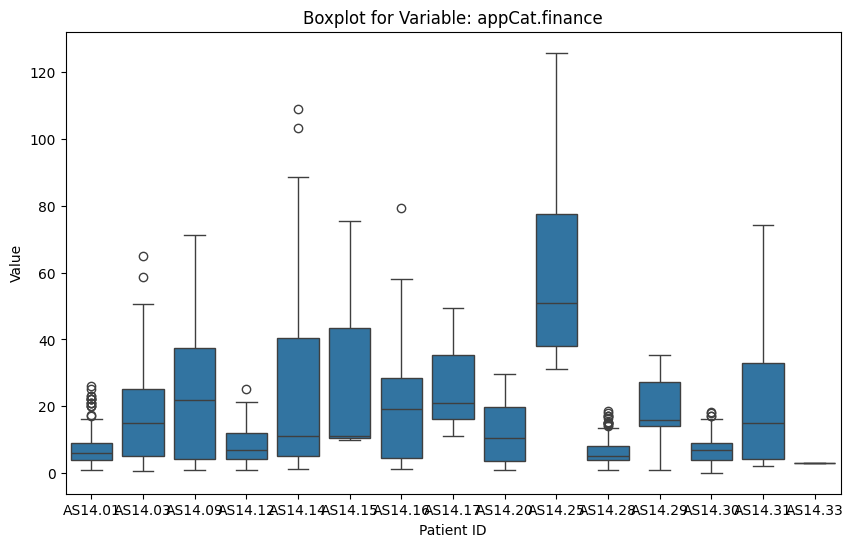

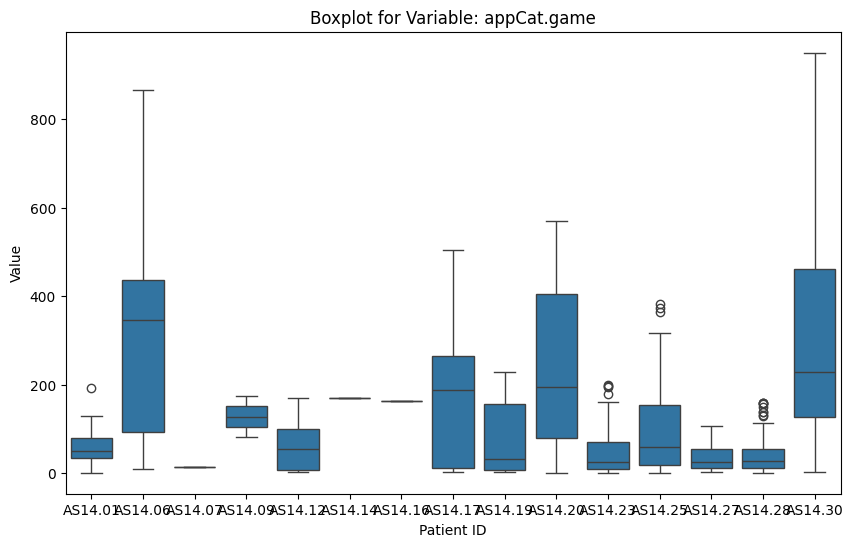

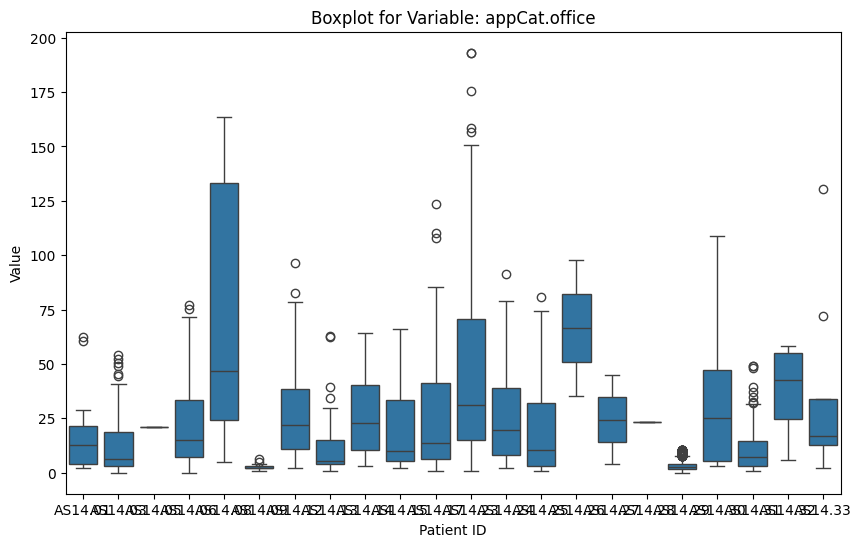

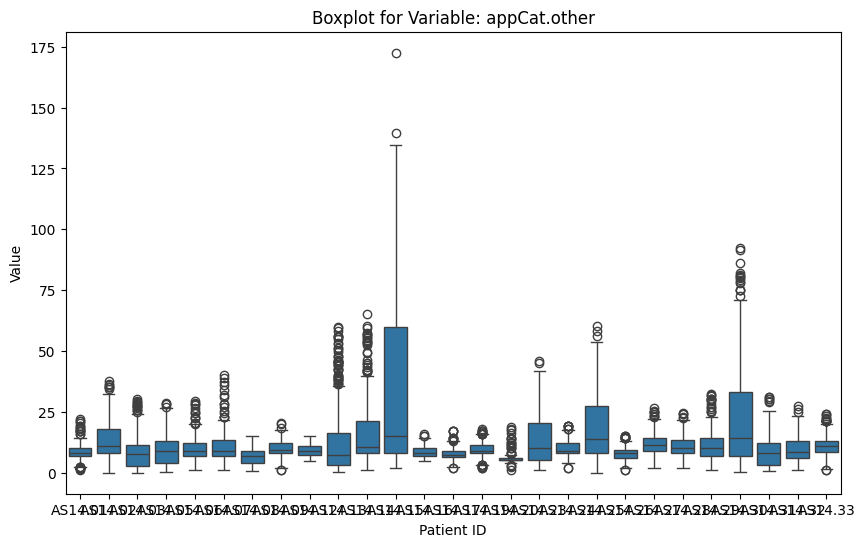

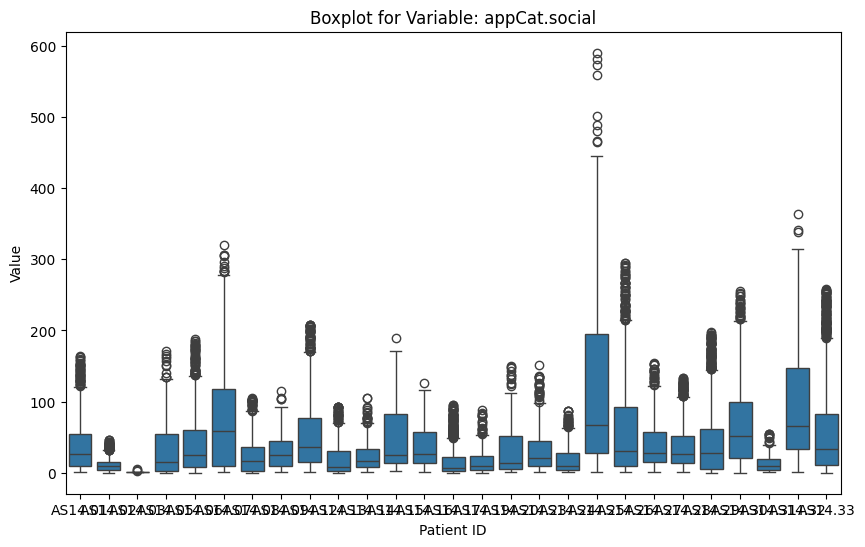

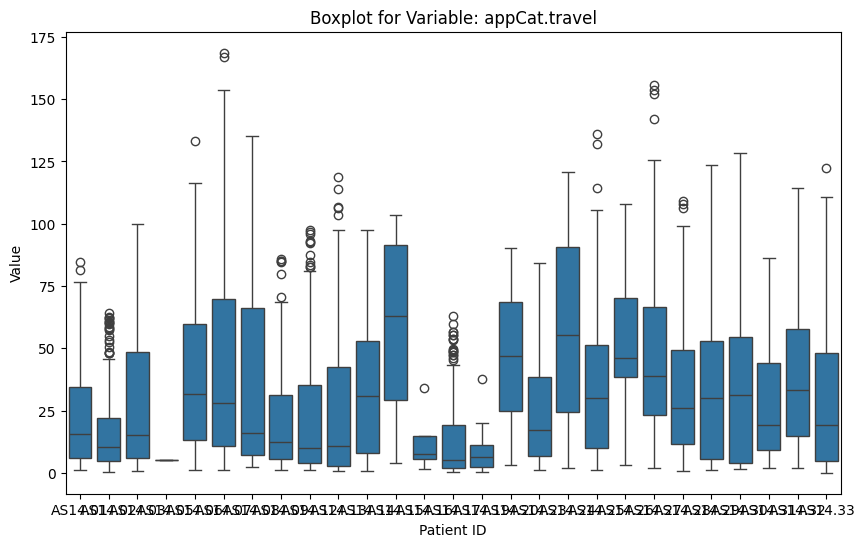

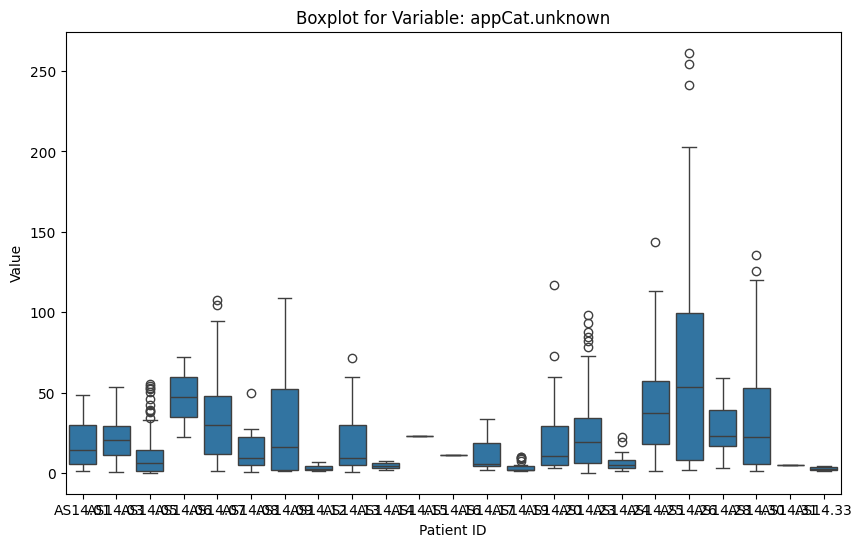

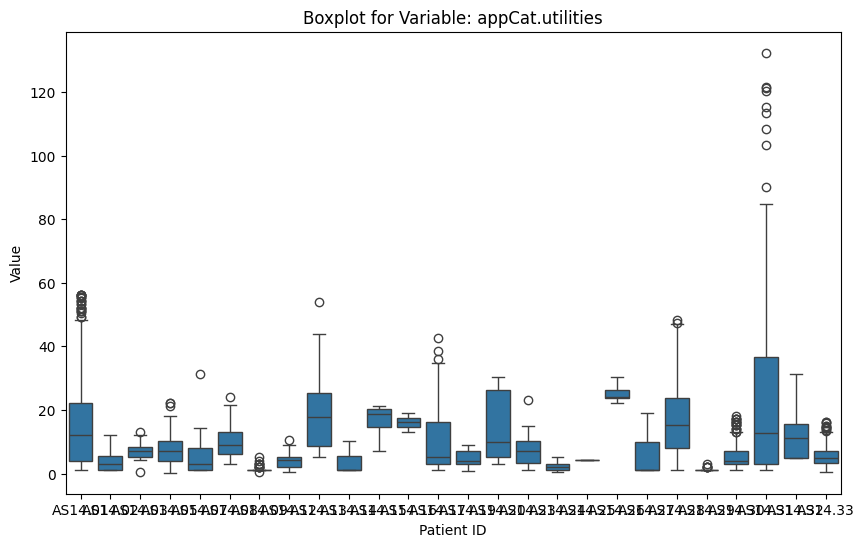

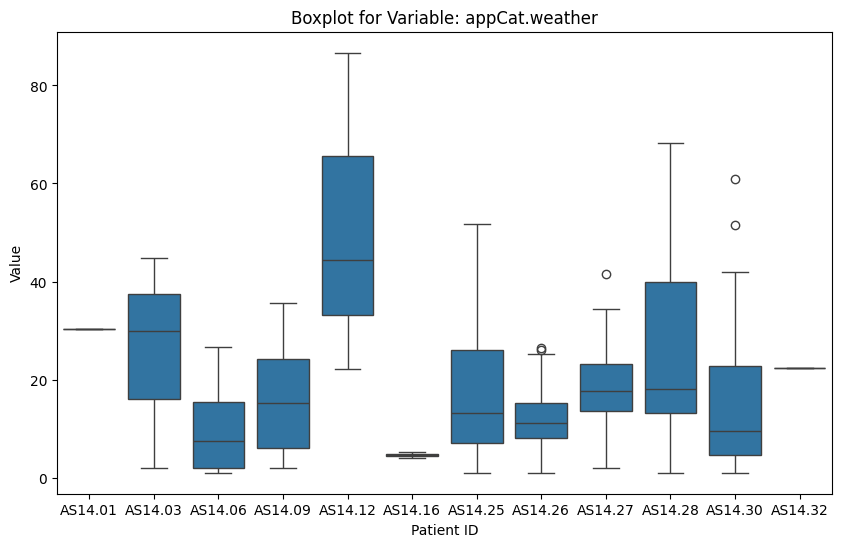

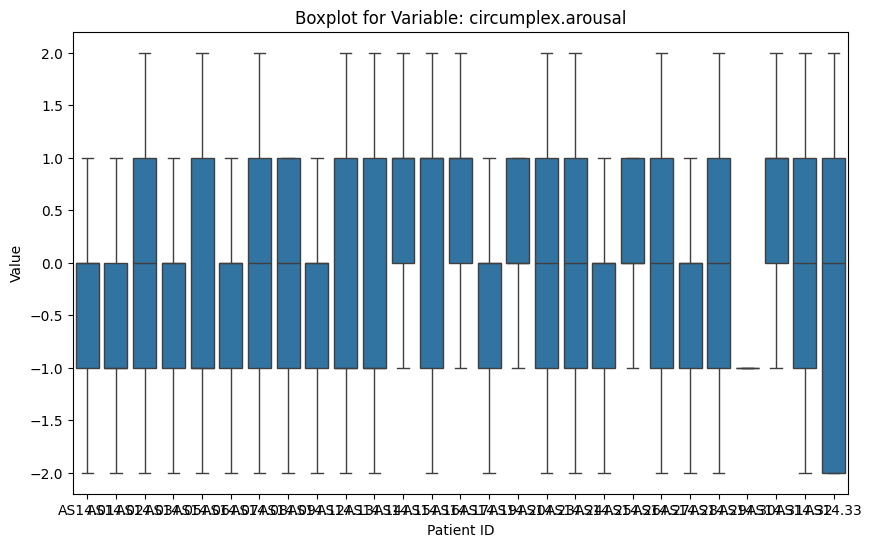

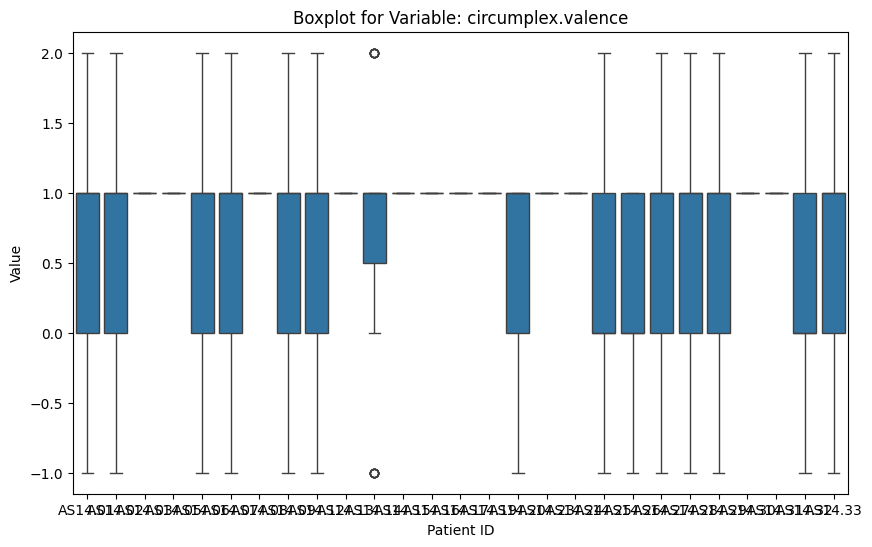

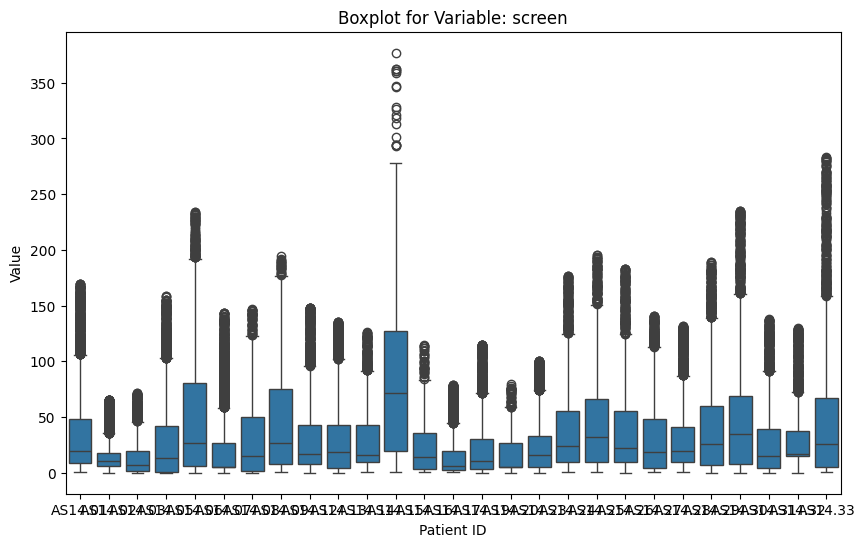

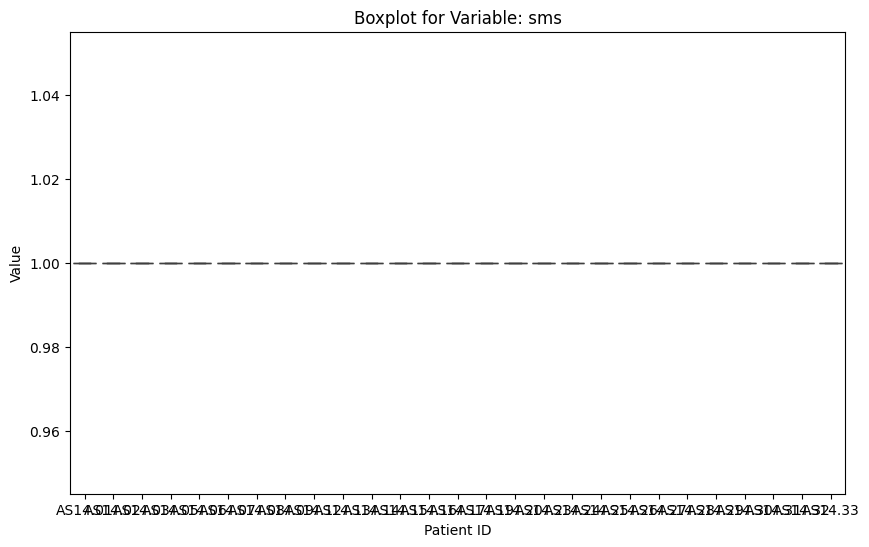

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 读取CSV文件
# df = pd.read_csv('dataset_mood_smartphone.csv')
df = pd.read_csv('cleaned_data.csv')


variables = df['variable'].unique()

# 为每个属性绘制包含所有患者的箱型图
for var in variables:
    plt.figure(figsize=(10, 6))

    # 创建当前属性的子集
    subset = df[df['variable'] == var]

    # 绘制箱型图，此处id作为x轴，value作为y轴
    sns.boxplot(x='id', y='value', data=subset, showfliers=True)

    # 设置图表标题和坐标轴标签
    plt.title(f'Boxplot for Variable: {var}')
    plt.xlabel('Patient ID')
    plt.ylabel('Value')

    # 显示图表
    plt.show()

### Impute NA with 0.6*day mean + 0.4(4days mean)

In [ ]:
import pandas as pd
import numpy as np

# 读取CSV文件
df = pd.read_csv('dataset_mood_smartphone.csv')

# 将时间列转换为pandas的datetime类型（如果尚未转换）
df['time'] = pd.to_datetime(df['time'])

# 确保数据按时间排序
df.sort_values(by=['id', 'variable', 'time'], inplace=True)

# 函数用于计算给定行的插值
def calculate_interpolated_value(row, df):
    # 只有当值是NA的时候才填充
    if pd.isna(row['value']):
        # 当日均值计算（只取当日的数据）
        daily_values = df[(df['id'] == row['id']) & (df['variable'] == row['variable']) & (df['time'].dt.date == row['time'].date())]['value']
        daily_mean = daily_values.mean()

        # 邻近四天的相同时间段值（前后各两天，如果存在）
        date_range = pd.date_range(start=row['time'].date() - pd.Timedelta(days=2), end=row['time'].date() + pd.Timedelta(days=2), freq='D').date
        date_range = date_range[date_range != row['time'].date()]  # 去掉当日
        adjacent_values = df[(df['id'] == row['id']) & (df['variable'] == row['variable']) & (df['time'].dt.date.isin(date_range)) & (df['time'].dt.time == row['time'].time())]['value']
        adjacent_mean = adjacent_values.mean()

        # 权重计算
        if np.isnan(daily_mean) and np.isnan(adjacent_mean):
            return np.nan  # 如果两个均值都是NaN，返回NaN
        elif np.isnan(daily_mean):
            return adjacent_mean  # 如果当日均值缺失，则只取邻近四天均值
        elif np.isnan(adjacent_mean):
            return daily_mean  # 如果邻近四天均值缺失，则只取当日均值
        else:
            # 结合两个均值填充NA值（60%当日均值和40%邻近四天均值）
            return 0.6 * daily_mean + 0.4 * adjacent_mean
    else:
        return row['value']

# 应用函数计算每一行可能的插值
df['value'] = df.apply(lambda row: calculate_interpolated_value(row, df), axis=1)

# 将处理后的DataFrame保存到新的CSV文件
df.to_csv('processed_data.csv', index=False)


### Clean outliers using Quartile

In [ ]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('processed_data.csv')

# 定义一个函数，用于去除分组中的异常值
def remove_outliers(group):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    # 定义异常值范围
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 只保留非异常值
    return group[(group['value'] >= lower_bound) & (group['value'] <= upper_bound)]

# 应用分组和异常值移除
cleaned_df = df.groupby(['id', 'variable']).apply(remove_outliers).reset_index(drop=True)

# 保存清洗后的数据到新的CSV文件
cleaned_df.to_csv('cleaned_data.csv', index=False)

### Calculate daily mean for each attribute of patients

In [3]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('cleaned_data.csv', parse_dates=['time'])

# 确保时间列是datetime类型
df['time'] = pd.to_datetime(df['time'])

# 提取日期部分作为一个新的列
df['date'] = df['time'].dt.date

# 按照id, variable和date分组，并计算每组的平均值
grouped_df = df.groupby(['id', 'variable', 'date'])['value'].mean().reset_index()
# 对variable为mood的值进行四舍五入
grouped_df.loc[grouped_df['variable'] == 'mood', 'value'] = grouped_df['value'].round()


# 保存到新的CSV文件
grouped_df.to_csv('daily_averages.csv', index=False)

### Transpose data be like: id, time, attr1, attr2...

In [1]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('daily_averages.csv')

# 确保时间列是datetime类型
df['date'] = pd.to_datetime(df['date'])

# 步骤2: 数据转换
# 使用pivot_table函数来重塑数据，将'variable'列的值转换为列头，'value'列的值填充到相应的位置
pivot_df = df.pivot_table(index=['id', 'date'], columns='variable', values='value', aggfunc='first').reset_index()


# 步骤3: 将指定列移动到最后
# 假设指定的列名为'attri5'
columns = list(pivot_df.columns)
columns.append(columns.pop(columns.index('mood')))
pivot_df = pivot_df[columns]

# 步骤4: 保存转换后的数据到新的CSV文件
pivot_df.to_csv('transposed_data.csv', index=False)

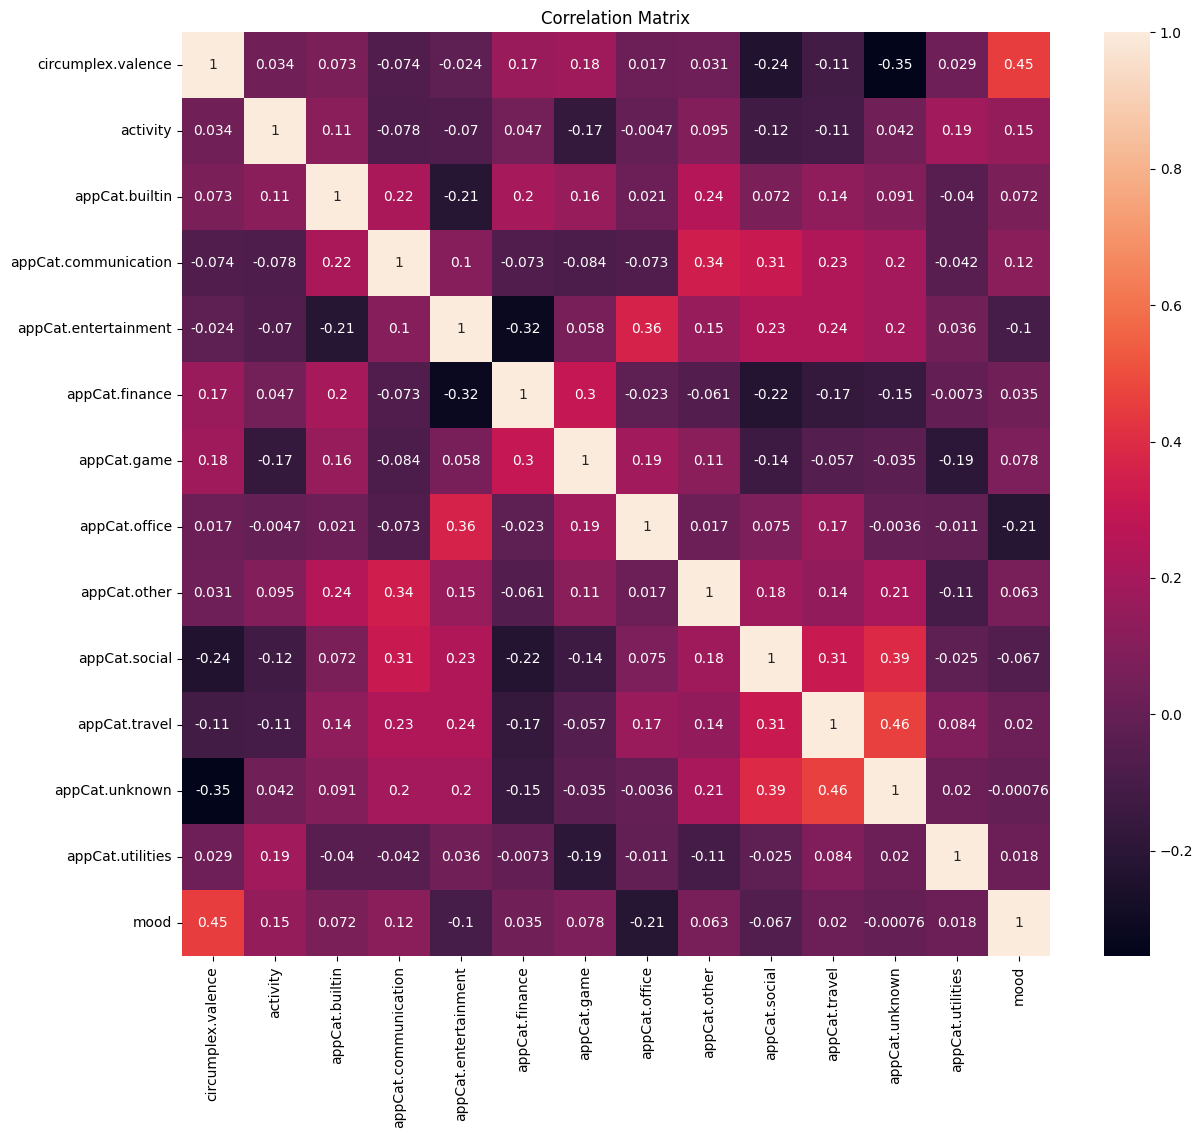

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 读取CSV文件
df1 = pd.read_csv('transposed_data.csv')
# df2 = pd.read_csv('data_imputed_knn.csv')
df3 = pd.read_csv('data_imputed_rf.csv')
# df4 = pd.read_csv('data_imputed_mean.csv')


continuous_variables = [

    'circumplex.valence',
    'activity',

    'appCat.builtin',
    'appCat.communication',
    'appCat.entertainment',
    'appCat.finance',
    'appCat.game',
    'appCat.office',
    'appCat.other',
    'appCat.social',
    'appCat.travel',
    'appCat.unknown',
    'appCat.utilities',

]


plt.figure(figsize=(14, 12))
correlation_matrix = df3[continuous_variables + ['mood']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()




### Clean call and sms

In [2]:
import pandas as pd

# 加载数据
df = pd.read_csv('transposed_data.csv') # 假设这是经过前面步骤处理过的文件

# 排除第一和第二列
df_without_first_two = df.iloc[:, 2:]  # 使用iloc来排除前两列

# 计算剩余属性的方差
variances = df_without_first_two.var()

# 设置方差的阈值
variance_threshold = 0.001  # 示例阈值

# 找出方差大于等于阈值的属性的列索引
columns_to_keep = variances[variances >= variance_threshold].index

# 将第一和第二列重新添加到要保留的列索引中
columns_to_keep = df.columns[:2].tolist() + columns_to_keep.tolist()

# 根据列索引筛选数据
df_filtered_variances = df[columns_to_keep]

# 保存新文件
df_filtered_variances.to_csv('filtered_variances.csv', index=False)

In [3]:
import pandas as pd

# 加载数据
df = pd.read_csv('filtered_variances.csv')

# 计算每个记录的缺失值数量
missing_per_row = df.isnull().sum(axis=1)

# 筛选出缺失值小于或等于15的记录
df_filtered_rows = df[missing_per_row <= 15]

# 保存新文件
df_filtered_rows.to_csv('filtered_rows.csv', index=False)

### Impute using KNN or RandomForest

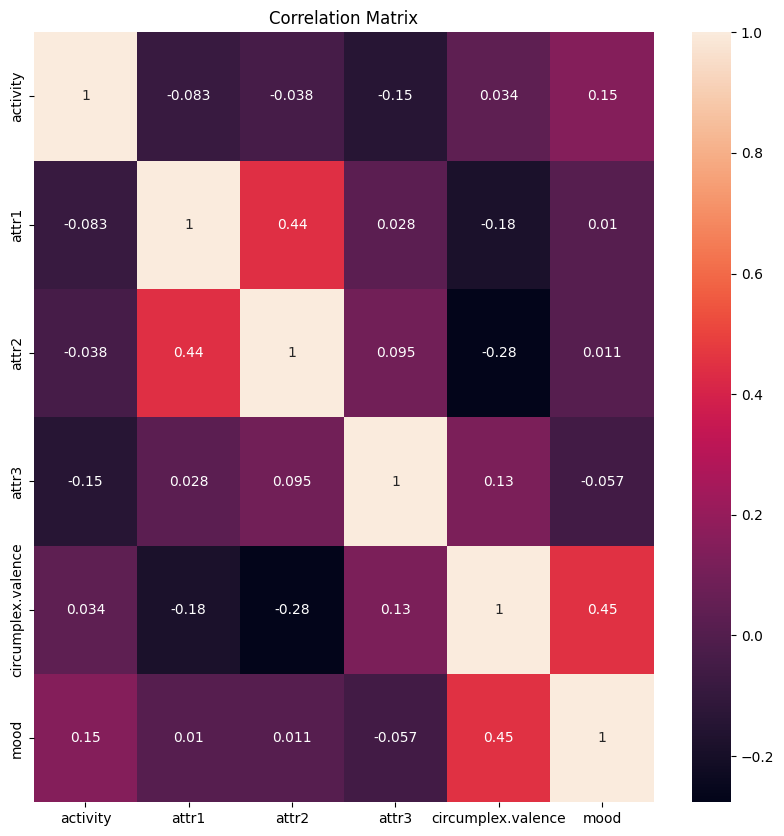

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 读取CSV文件
df = pd.read_csv('modified_data.csv')

continuous_variables = df.columns.values.tolist()[2:]
plt.figure(figsize=(10, 10))
correlation_matrix = df[continuous_variables].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# 假设CSV文件名为 'data.csv'
df = pd.read_csv('filtered_rows.csv', parse_dates=['date'])

# 标准化除了'id'和'date'之外的数值型特征
scaler = StandardScaler()
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# 将日期转换为时间戳，这个操作可以将时间转换为一个数值型特征，以便KNN算法使用
df['timestamp'] = df['date'].values.astype(np.int64) // 10 ** 9

# 使用KNN插补器插补缺失值
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=['id', 'date'])), columns=df.drop(columns=['id', 'date']).columns)
df_imputed.insert(0, 'date', df['date'])
df_imputed.insert(0, 'id', df['id'])

# 逆向标准化数值型特征
df_imputed[numeric_features] = scaler.inverse_transform(df_imputed[numeric_features])
df_imputed.drop(columns=['timestamp'], inplace=True)

df_imputed.to_csv('data_imputed_knn.csv', index=False)

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# 步骤 1: 加载数据并解析日期
df = pd.read_csv('filtered_rows.csv', parse_dates=['date'])

# 步骤 2: 预处理数据 - 将日期转换为数值型特征（例如：日数差）
df['date_numeric'] = (df['date'] - df['date'].min()) / pd.Timedelta('1D')

# 步骤 3: 计算每个属性的缺失值数量，并按照缺失数量排序
missing_counts = df.isnull().sum().sort_values()

# 步骤 4: 对非目标属性填充缺失值
features = df.columns.drop(['id', 'date', 'date_numeric'])
# 使用均值进行初步插补
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)
df_imputed = pd.concat([df[['id', 'date', 'date_numeric']], df_imputed], axis=1)

# 步骤 5: 按照缺失数量从少到多进行插补
for feature in missing_counts.index:
    if feature not in ['id', 'date', 'date_numeric']:  # 跳过非数值型特征
        missing_indexes = df[feature].isnull()
        if missing_indexes.any():
            # 创建预测模型，使用除了目标特征外的其他特征作为预测器
            predictor_features = df_imputed.columns.drop([feature, 'id', 'date'])
            rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
            # 训练模型 (只使用有目标特征值的行)
            rf.fit(df_imputed.loc[~missing_indexes, predictor_features], df_imputed.loc[~missing_indexes, feature])
            # 预测缺失值
            predicted_values = rf.predict(df_imputed.loc[missing_indexes, predictor_features])
            # 填充缺失值
            df_imputed.loc[missing_indexes, feature] = predicted_values

# 步骤 6: 删除辅助的 'date_numeric' 列并恢复原始的 'date' 列顺序
df_imputed.drop(columns=['date_numeric'], inplace=True)
df_imputed = df_imputed[['id', 'date'] + [col for col in df_imputed.columns if col not in ['id', 'date']]]
df_imputed['mood'] = df_imputed['mood'].round()

# 步骤 7: 输出插补后的数据
df_imputed.to_csv('data_imputed_rf.csv', index=False)

In [ ]:
import pandas as pd

# 加载数据
df = pd.read_csv('filtered_rows.csv')

# 选择除了'id'和'date'以外的数值型列
numeric_columns = df.select_dtypes(include=['number']).columns

# 对选定的数值型列进行均值插补
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# 确认插补后没有缺失值
assert df[numeric_columns].isnull().sum().sum() == 0

# 保存插补后的数据
df.to_csv('data_imputed_mean.csv', index=False)

### Feature selecting or combination
1. remove attributes with low mean


### 正态分布 填充数据后的

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

data = pd.read_csv('data_imputed_rf.csv')


# 计算每个属性的均值和标准差
stats = data.describe().T  # .T 转置使得每个属性为一行


# 为每个属性画正态分布图
for column in data.columns[2:]:  # 跳过前两列 id 和 date
    mu = stats.loc[column, 'mean']  # 均值
    sigma = stats.loc[column, 'std']  # 标准差

    # 生成符合正态分布的数据
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

    # 计算正态分布的概率密度函数(PDF)
    y = norm.pdf(x, mu, sigma)

    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label=f'{column} Normal Distribution')
    plt.title(f'Normal Distribution for {column}')
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

        id        date  activity  appCat.builtin  appCat.communication  \
0  AS14.01  2014-02-26  0.030298        5.619643             17.543730   
1  AS14.01  2014-02-27  0.063356        5.538735             20.438577   
2  AS14.01  2014-03-20  0.081548        3.036650             32.051882   
3  AS14.01  2014-03-21  0.046408        4.691908             29.082061   
4  AS14.01  2014-03-22  0.153065        4.843341             25.056780   

   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
0             61.983947       11.915963    58.558318      26.497735   
1             58.453061       10.397127    36.542145      20.150752   
2             58.476000       16.046879    85.862927      21.198968   
3             53.024000        6.193000    64.126407      33.880000   
4             46.662000        7.025333    31.043561      16.205908   

   appCat.other  appCat.social  appCat.travel  appCat.unknown  \
0     16.024279      49.108733      40.307242       20.742071  

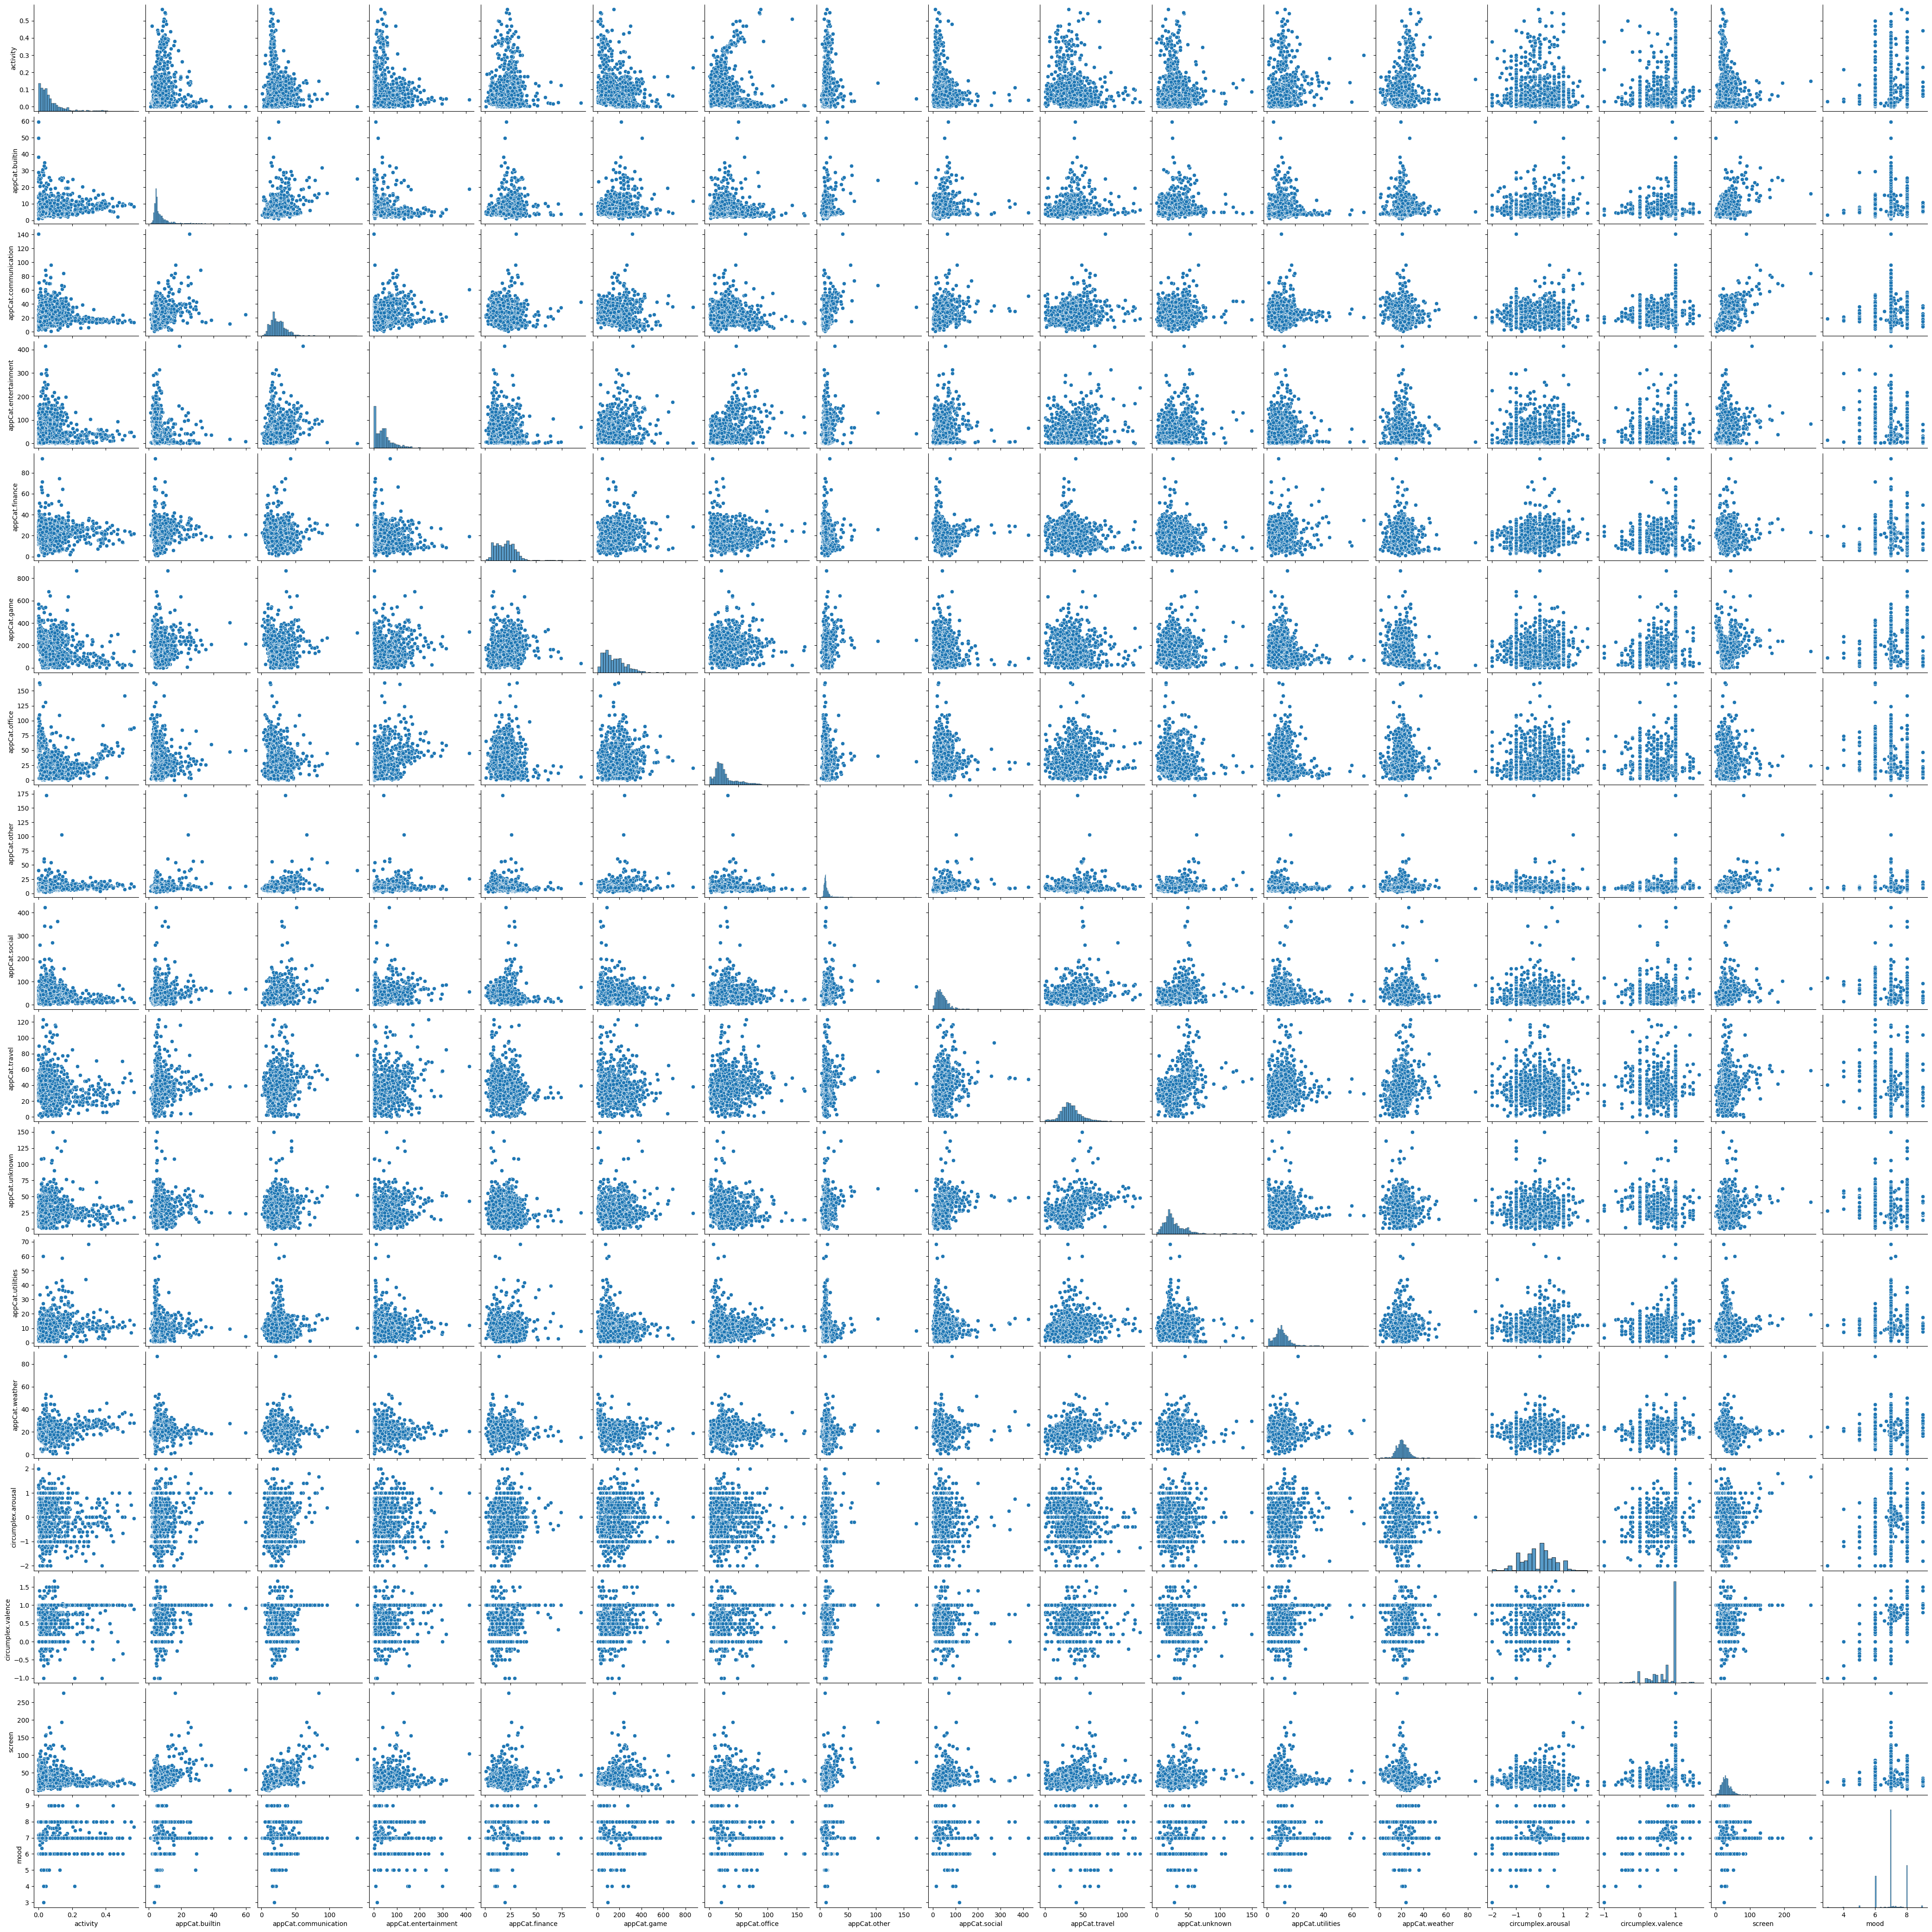

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('data_imputed_rf.csv')

# 2. 数据清洗
# 查看数据情况
print(data.head())
# 检查并处理缺失值，这里选择删除含缺失值的行
data = data.dropna()

# 3. 绘制散点图
# 选择属性列，这里假设从第3列开始是我们关心的属性列
attributes = data.columns[2:]

# 使用seaborn绘制两两属性之间的散点图
sns.pairplot(data[attributes])
plt.show()

# 如果数据集的属性特别多，可能不想要一次性绘制所有属性的pairplot，因为这会生成非常多的图表，
# 可以选择绘制部分属性的pairplot
# 例如，只绘制前4个属性的pairplot
# sns.pairplot(data[attributes[:4]])
# plt.show()

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 加载数据
df = pd.read_csv('data_imputed_rf.csv')

# 假设数据已经是时间序列分布均匀的
# 预处理可能包括填充缺失值、转换数据类型等
# ...

# 分离特征和标签
X = df.drop(['id', 'date', 'mood'], axis=1)  # 移除id、date和目标变量mood
y = df['mood']


# 使用随机森林估计器
forest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 训练模型
forest.fit(X, y)

# 获取特征重要性
importances = forest.feature_importances_

# 将特征名称和其重要性分数结合在一起
features = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]

# 对特征重要性进行排序
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# 选择前10个最重要的特征
top_features = feature_importances[:]

# 打印特征及其重要性
for feature in top_features:
    print(f"Feature: {feature[0]}, Importance: {feature[1]}")

Feature: circumplex.valence, Importance: 0.24
Feature: activity, Importance: 0.09
Feature: appCat.office, Importance: 0.09
Feature: appCat.builtin, Importance: 0.06
Feature: appCat.entertainment, Importance: 0.06
Feature: appCat.communication, Importance: 0.05
Feature: appCat.unknown, Importance: 0.05
Feature: appCat.finance, Importance: 0.04
Feature: appCat.game, Importance: 0.04
Feature: appCat.other, Importance: 0.04
Feature: appCat.social, Importance: 0.04
Feature: appCat.travel, Importance: 0.04
Feature: appCat.utilities, Importance: 0.04
Feature: circumplex.arousal, Importance: 0.04
Feature: appCat.weather, Importance: 0.03
Feature: screen, Importance: 0.03


### Task1C Feature engineering

In [26]:
import pandas as pd

# 步骤1: 加载CSV文件
df = pd.read_csv('data_imputed_rf.csv')

# 步骤2: 删除指定的列
df.drop(['circumplex.arousal', 'screen', 'appCat.utilities', 'appCat.weather'], axis=1, inplace=True)

# 步骤3: 创建新的列作为特定列的加权和
df.insert(5, column = 'attr3', value = 0.26 * df['appCat.entertainment'] + 0.175 * df['appCat.game'] + 0.39 * df['appCat.office'] + 0.175 * df['appCat.finance'])

# 步骤4: 创建另一个新的列作为两列的加权平均
df.insert(5, column = 'attr2', value=0.5 * df['appCat.travel'] + 0.5 * df['appCat.unknown'])

df.insert(5, column = 'attr1', value=0.32 * df['appCat.builtin'] + 0.26 * df['appCat.communication'] + 0.21 * df['appCat.other'] + 0.21 * df['appCat.social'])

df.drop(['appCat.entertainment','appCat.game','appCat.office','appCat.finance','appCat.travel','appCat.unknown','appCat.builtin','appCat.communication','appCat.other','appCat.social'], axis=1, inplace=True)

# 现在您可以选择保存这个修改后的DataFrame到新的CSV文件
df.to_csv('modified_data.csv', index=False)